# 个性化推荐
本项目使用文本卷积神经网络，并使用[`MovieLens`](https://grouplens.org/datasets/movielens/)数据集完成电影推荐的任务。



推荐系统在日常的网络应用中无处不在，比如网上购物、网上买书、新闻app、社交网络、音乐网站、电影网站等等等等，有人的地方就有推荐。根据个人的喜好，相同喜好人群的习惯等信息进行个性化的内容推荐。比如打开新闻类的app，因为有了个性化的内容，每个人看到的新闻首页都是不一样的。

这当然是很有用的，在信息爆炸的今天，获取信息的途径和方式多种多样，人们花费时间最多的不再是去哪获取信息，而是要在众多的信息中寻找自己感兴趣的，这就是信息超载问题。为了解决这个问题，推荐系统应运而生。

协同过滤是推荐系统应用较广泛的技术，该方法搜集用户的历史记录、个人喜好等信息，计算与其他用户的相似度，利用相似用户的评价来预测目标用户对特定项目的喜好程度。优点是会给用户推荐未浏览过的项目，缺点呢，对于新用户来说，没有任何与商品的交互记录和个人喜好等信息，存在冷启动问题，导致模型无法找到相似的用户或商品。

为了解决冷启动的问题，通常的做法是对于刚注册的用户，要求用户先选择自己感兴趣的话题、群组、商品、性格、喜欢的音乐类型等信息，比如豆瓣FM：
<img src="assets/IMG_6242_300.PNG"/>

## 下载数据集
运行下面代码把[`数据集`](http://files.grouplens.org/datasets/movielens/ml-1m.zip)下载下来

In [6]:
tf.__version__

'2.0.0-dev20190301'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [7]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [8]:
data_dir = './'
download_extract('ml-1m', data_dir)

Extracting ml-1m...
Done.


## 先来看看数据

本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [6]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [7]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [8]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

## 来说说数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

## 实现数据预处理

In [9]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [10]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 预处理后的数据

In [13]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [14]:
movies.head()

,MovieID,Title,Genres
0,1,"[3258, 3347, 2746, 2746, 2746, 2746, 2746, 274...","[16, 11, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
1,2,"[3318, 2746, 2746, 2746, 2746, 2746, 2746, 274...","[7, 11, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10,..."
2,3,"[2286, 3451, 1085, 2746, 2746, 2746, 2746, 274...","[5, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
3,4,"[251, 4209, 3270, 2746, 2746, 2746, 2746, 2746...","[5, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
4,5,"[4457, 2615, 1663, 4559, 2474, 3519, 2746, 274...","[5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."


In [15]:
movies.values[0]

array([1,
       list([3258, 3347, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746, 2746]),
       list([16, 11, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])],
      dtype=object)

### 从本地读取数据

In [ ]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 模型设计

<img src="assets/model.001.jpeg"/>

通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我这小笔记本不像大厂动辄能处理数以亿计维度的输入：）

所以在预处理数据时将这些字段转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

电影名的处理比较特殊，没有使用循环神经网络，而是用了文本卷积网络，下文会进行说明。

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层，最终分别得到（1，200）的用户特征和电影特征两个特征向量。

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。我使用了两种方式，一个是上图中画出的将两个特征做向量乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题，另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

实际上第二个方式的MSE loss在0.8附近，第一个方式在1附近，5次迭代的结果。

## 文本卷积网络
网络看起来像下面这样

<img src="assets/text_cnn.png"/>
图片来自Kim Yoon的论文：[`Convolutional Neural Networks for Sentence Classification`](https://arxiv.org/abs/1408.5882)

将卷积神经网络用于文本的文章建议你阅读[`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [11]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


## 编码实现

In [12]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [13]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### 输入

定义输入的占位符

In [14]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

## 构建神经网络

#### 定义User的嵌入矩阵

In [15]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [16]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    #第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    #第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [17]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

#### 合并电影类型的多个嵌入向量

In [18]:
def get_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
#     movie_categories_embed_layer = tf.keras.layers.Reshape([1, 18 * embed_dim])(movie_categories_embed_layer)

    return movie_categories_embed_layer

#### Movie Title的文本卷积网络实现

In [19]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    #Dropout层
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

#### 将Movie的各个层一起做全连接

In [20]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    #第一层全连接
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    #第二层全连接
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

In [ ]:
tf.keras.layers.

## 构建计算图

In [24]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # 获取输入占位符
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        # 获取User的4个嵌入向量
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender,
                                                                                                   user_age, user_job)
        # 得到用户特征
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
        # 获取电影ID的嵌入向量
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
        # 获取电影类型的嵌入向量
        movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
        # 获取电影名的特征向量
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
        # 得到电影特征
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)
        # 计算出评分
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        
        # 将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],
#                                                       1)  # (?, 400)
        # 你可以使用下面这个全连接层，试试效果
        #inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(
        #    inference_layer)
#         inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE损失，将计算值回归到评分
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        #         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        #         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            # 将数据集分成训练集和测试集，随机种子不固定
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            #             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                #                 avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    #                     avg_mae(metrics)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        #                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        #     self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        # avg_mae.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            #             with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # 保存测试损失
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions


## 取得batch

In [22]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

将用户特征和电影特征作为输入，经过全连接，输出一个值的训练

In [187]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166880      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape_41 (Reshape)            (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 14, 1, 8)     520         reshape_41[0][0]                 
____________________________________________________________________________________________

Step #15650	Epoch   0 Batch   24/3125   Loss: 0.719377 mae: 0.712000 (3.5135560911641575 steps/sec)
Step #15700	Epoch   0 Batch   74/3125   Loss: 0.866670 mae: 0.709394 (25.830771074540085 steps/sec)
Step #15750	Epoch   0 Batch  124/3125   Loss: 0.700602 mae: 0.718584 (26.19073666941918 steps/sec)
Step #15800	Epoch   0 Batch  174/3125   Loss: 0.746907 mae: 0.717255 (26.54184004517734 steps/sec)
Step #15850	Epoch   0 Batch  224/3125   Loss: 0.604826 mae: 0.712918 (26.49214363385736 steps/sec)
Step #15900	Epoch   0 Batch  274/3125   Loss: 0.818413 mae: 0.713236 (25.899945523901128 steps/sec)
Step #15950	Epoch   0 Batch  324/3125   Loss: 0.787888 mae: 0.715860 (25.442358006871 steps/sec)
Step #16000	Epoch   0 Batch  374/3125   Loss: 0.797755 mae: 0.717225 (24.36439334037065 steps/sec)
Step #16050	Epoch   0 Batch  424/3125   Loss: 0.872372 mae: 0.720618 (24.813824025352993 steps/sec)
Step #16100	Epoch   0 Batch  474/3125   Loss: 0.793410 mae: 0.715396 (25.03474707128417 steps/sec)
Step #16

Step #19700	Epoch   1 Batch  949/3125   Loss: 0.705293 mae: 0.712794 (25.831477407840843 steps/sec)
Step #19750	Epoch   1 Batch  999/3125   Loss: 0.858537 mae: 0.712239 (25.8981224172447 steps/sec)
Step #19800	Epoch   1 Batch 1049/3125   Loss: 0.881791 mae: 0.718265 (26.16095643612056 steps/sec)
Step #19850	Epoch   1 Batch 1099/3125   Loss: 0.783116 mae: 0.712359 (26.222463407497806 steps/sec)
Step #19900	Epoch   1 Batch 1149/3125   Loss: 0.745023 mae: 0.717032 (26.26694373757906 steps/sec)
Step #19950	Epoch   1 Batch 1199/3125   Loss: 0.823196 mae: 0.710118 (26.31572210905037 steps/sec)
Step #20000	Epoch   1 Batch 1249/3125   Loss: 0.900386 mae: 0.719564 (25.691107466186548 steps/sec)
Step #20050	Epoch   1 Batch 1299/3125   Loss: 0.789442 mae: 0.722340 (26.12615564354447 steps/sec)
Step #20100	Epoch   1 Batch 1349/3125   Loss: 0.844146 mae: 0.702390 (26.74591829095639 steps/sec)
Step #20150	Epoch   1 Batch 1399/3125   Loss: 0.825736 mae: 0.717600 (26.40209912319155 steps/sec)
Step #20

Step #23800	Epoch   2 Batch 1924/3125   Loss: 1.000547 mae: 0.713107 (26.06307129230903 steps/sec)
Step #23850	Epoch   2 Batch 1974/3125   Loss: 0.820561 mae: 0.710344 (24.72029312347086 steps/sec)
Step #23900	Epoch   2 Batch 2024/3125   Loss: 0.864284 mae: 0.719297 (25.093330372287674 steps/sec)
Step #23950	Epoch   2 Batch 2074/3125   Loss: 0.889233 mae: 0.710738 (26.36612054491062 steps/sec)
Step #24000	Epoch   2 Batch 2124/3125   Loss: 0.654758 mae: 0.714532 (25.1849736465619 steps/sec)
Step #24050	Epoch   2 Batch 2174/3125   Loss: 0.718836 mae: 0.705476 (23.854425073244386 steps/sec)
Step #24100	Epoch   2 Batch 2224/3125   Loss: 0.710718 mae: 0.712394 (25.755327386416738 steps/sec)
Step #24150	Epoch   2 Batch 2274/3125   Loss: 0.838033 mae: 0.713050 (25.50518063035918 steps/sec)
Step #24200	Epoch   2 Batch 2324/3125   Loss: 0.688421 mae: 0.721697 (25.327139643991682 steps/sec)
Step #24250	Epoch   2 Batch 2374/3125   Loss: 0.779463 mae: 0.712504 (26.03148327489811 steps/sec)
Step #2

Step #27900	Epoch   3 Batch 2899/3125   Loss: 0.828528 mae: 0.710024 (25.986971768199133 steps/sec)
Step #27950	Epoch   3 Batch 2949/3125   Loss: 0.848071 mae: 0.713094 (24.17492199051817 steps/sec)
Step #28000	Epoch   3 Batch 2999/3125   Loss: 0.742095 mae: 0.710113 (24.281360861792685 steps/sec)
Step #28050	Epoch   3 Batch 3049/3125   Loss: 0.765247 mae: 0.702206 (26.061115036633282 steps/sec)
Step #28100	Epoch   3 Batch 3099/3125   Loss: 0.851693 mae: 0.707014 (26.171730265268764 steps/sec)

Train time for epoch #4 (28125 total steps): 121.49230313301086
Model test set loss: 0.834679 mae: 0.720304
Step #28150	Epoch   4 Batch   24/3125   Loss: 0.713022 mae: 0.719945 (49.21506834109367 steps/sec)
Step #28200	Epoch   4 Batch   74/3125   Loss: 0.858430 mae: 0.706423 (26.073550679230795 steps/sec)
Step #28250	Epoch   4 Batch  124/3125   Loss: 0.681727 mae: 0.715435 (26.440826013567182 steps/sec)
Step #28300	Epoch   4 Batch  174/3125   Loss: 0.743057 mae: 0.713319 (25.724357422196512 step

将用户特征和电影特征做矩阵乘法得到一个预测评分的训练

In [25]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166880      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 1, 8)     520         reshape_1[0][0]                  
____________________________________________________________________________________________

W0304 21:47:02.173334 4664485312 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x1424cc6d8> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Object conversion is not yet supported. If you are trying to convert code that uses an existing object, try including the creation of that object in the conversion. For example, instead of converting the method of a class, try converting the entire class instead. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/README.md#using-the-functional-api for more information.
W0304 21:47:02.189912 4664485312 tf_logging.py:161] Entity <method-wrapper '__call__' of weakref object at 0x14202c548> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_V

Step #9400	Epoch   0 Batch   24/3125   Loss: 1.117654 mae: 0.922864 (3.922135854210507 steps/sec)
Step #9450	Epoch   0 Batch   74/3125   Loss: 1.216622 mae: 0.908119 (18.10271254276855 steps/sec)
Step #9500	Epoch   0 Batch  124/3125   Loss: 1.016003 mae: 0.886247 (21.449404144579574 steps/sec)
Step #9550	Epoch   0 Batch  174/3125   Loss: 0.969421 mae: 0.850738 (20.694946526140697 steps/sec)
Step #9600	Epoch   0 Batch  224/3125   Loss: 0.744969 mae: 0.810330 (14.541664291769655 steps/sec)
Step #9650	Epoch   0 Batch  274/3125   Loss: 0.990777 mae: 0.788238 (16.664443047851137 steps/sec)
Step #9700	Epoch   0 Batch  324/3125   Loss: 0.984966 mae: 0.782725 (20.205285076679615 steps/sec)
Step #9750	Epoch   0 Batch  374/3125   Loss: 0.903125 mae: 0.775597 (19.32058917906161 steps/sec)
Step #9800	Epoch   0 Batch  424/3125   Loss: 0.948713 mae: 0.765667 (20.566152899882162 steps/sec)
Step #9850	Epoch   0 Batch  474/3125   Loss: 0.908609 mae: 0.759096 (19.634737953294806 steps/sec)
Step #9900	Ep

Step #11450	Epoch   0 Batch 2074/3125   Loss: 0.919819 mae: 0.722572 (20.934735576119202 steps/sec)
Step #11500	Epoch   0 Batch 2124/3125   Loss: 0.674401 mae: 0.726368 (16.453603886189796 steps/sec)
Step #11550	Epoch   0 Batch 2174/3125   Loss: 0.761150 mae: 0.717496 (14.790782025840452 steps/sec)
Step #11600	Epoch   0 Batch 2224/3125   Loss: 0.736960 mae: 0.723739 (13.705534824468481 steps/sec)
Step #11650	Epoch   0 Batch 2274/3125   Loss: 0.855284 mae: 0.724616 (17.67309189105737 steps/sec)
Step #11700	Epoch   0 Batch 2324/3125   Loss: 0.696391 mae: 0.732655 (19.362201572960988 steps/sec)
Step #11750	Epoch   0 Batch 2374/3125   Loss: 0.782445 mae: 0.722666 (19.077592049305224 steps/sec)
Step #11800	Epoch   0 Batch 2424/3125   Loss: 0.792556 mae: 0.726266 (18.253843909524594 steps/sec)
Step #11850	Epoch   0 Batch 2474/3125   Loss: 0.908641 mae: 0.719441 (18.58504585618521 steps/sec)
Step #11900	Epoch   0 Batch 2524/3125   Loss: 0.802004 mae: 0.728494 (19.73385411123686 steps/sec)
Ste

Step #15500	Epoch   1 Batch 2999/3125   Loss: 0.745186 mae: 0.713889 (17.02420313914268 steps/sec)
Step #15550	Epoch   1 Batch 3049/3125   Loss: 0.781694 mae: 0.705353 (18.916078141462705 steps/sec)
Step #15600	Epoch   1 Batch 3099/3125   Loss: 0.879136 mae: 0.710527 (18.563360246927022 steps/sec)

Train time for epoch #2 (15625 total steps): 166.3247570991516
Model test set loss: 0.827377 mae: 0.719194
best loss = 0.8273772597312927
Step #15650	Epoch   2 Batch   24/3125   Loss: 0.722387 mae: 0.718930 (33.1196217087886 steps/sec)
Step #15700	Epoch   2 Batch   74/3125   Loss: 0.868104 mae: 0.707424 (13.334583823594398 steps/sec)
Step #15750	Epoch   2 Batch  124/3125   Loss: 0.704735 mae: 0.718248 (17.513203472223207 steps/sec)
Step #15800	Epoch   2 Batch  174/3125   Loss: 0.745867 mae: 0.715609 (17.495324907265648 steps/sec)
Step #15850	Epoch   2 Batch  224/3125   Loss: 0.616620 mae: 0.710086 (18.42146594375193 steps/sec)
Step #15900	Epoch   2 Batch  274/3125   Loss: 0.809966 mae: 0.711

Step #19500	Epoch   3 Batch  749/3125   Loss: 0.768156 mae: 0.695677 (19.467888434898 steps/sec)
Step #19550	Epoch   3 Batch  799/3125   Loss: 0.872204 mae: 0.706183 (20.756601991657973 steps/sec)
Step #19600	Epoch   3 Batch  849/3125   Loss: 0.926446 mae: 0.705749 (19.8480057701741 steps/sec)
Step #19650	Epoch   3 Batch  899/3125   Loss: 0.872620 mae: 0.704646 (20.311842146681162 steps/sec)
Step #19700	Epoch   3 Batch  949/3125   Loss: 0.694071 mae: 0.704013 (18.6387715051348 steps/sec)
Step #19750	Epoch   3 Batch  999/3125   Loss: 0.855050 mae: 0.701800 (18.2450063243901 steps/sec)
Step #19800	Epoch   3 Batch 1049/3125   Loss: 0.848925 mae: 0.709953 (17.620785003269734 steps/sec)
Step #19850	Epoch   3 Batch 1099/3125   Loss: 0.747028 mae: 0.703682 (18.364380342973075 steps/sec)
Step #19900	Epoch   3 Batch 1149/3125   Loss: 0.739013 mae: 0.709048 (16.60404116395314 steps/sec)
Step #19950	Epoch   3 Batch 1199/3125   Loss: 0.835142 mae: 0.699206 (19.742964666232044 steps/sec)
Step #2000

Step #23550	Epoch   4 Batch 1674/3125   Loss: 0.711291 mae: 0.699889 (17.783771792657436 steps/sec)
Step #23600	Epoch   4 Batch 1724/3125   Loss: 0.869617 mae: 0.695721 (18.041441896228882 steps/sec)
Step #23650	Epoch   4 Batch 1774/3125   Loss: 0.762498 mae: 0.697375 (15.748884403456422 steps/sec)
Step #23700	Epoch   4 Batch 1824/3125   Loss: 0.699742 mae: 0.698182 (18.953381044431836 steps/sec)
Step #23750	Epoch   4 Batch 1874/3125   Loss: 0.867409 mae: 0.700424 (20.27585736151225 steps/sec)
Step #23800	Epoch   4 Batch 1924/3125   Loss: 0.965006 mae: 0.694853 (21.02829850880362 steps/sec)
Step #23850	Epoch   4 Batch 1974/3125   Loss: 0.761518 mae: 0.692496 (20.49723048437593 steps/sec)
Step #23900	Epoch   4 Batch 2024/3125   Loss: 0.853272 mae: 0.702434 (20.60425533001901 steps/sec)
Step #23950	Epoch   4 Batch 2074/3125   Loss: 0.839018 mae: 0.691413 (19.89791411536557 steps/sec)
Step #24000	Epoch   4 Batch 2124/3125   Loss: 0.636414 mae: 0.695023 (19.9965940554635 steps/sec)
Step #2

## 显示训练Loss

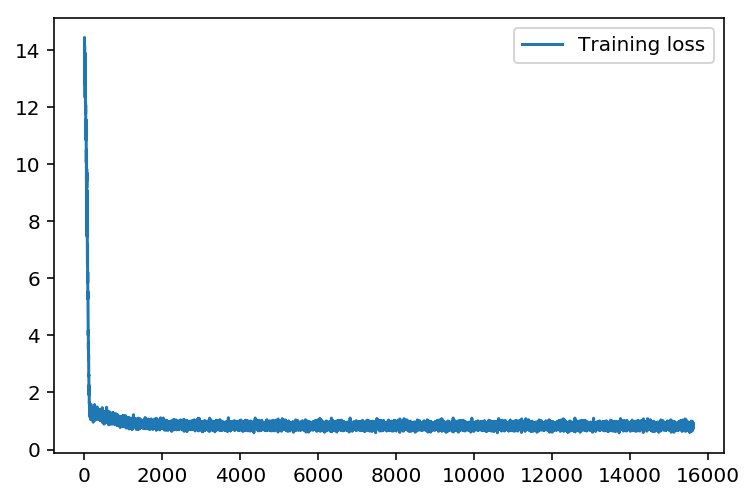

In [166]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

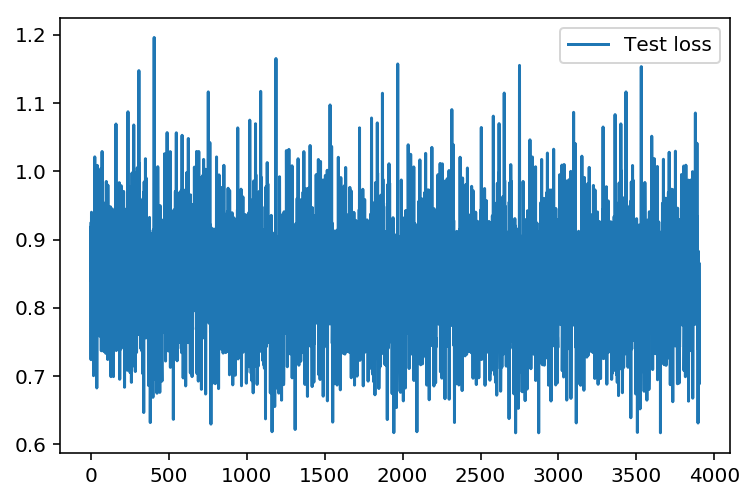

In [167]:
plt.plot(mv_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [140]:
def rating_movie(mv_net, user_id_val, movie_id_val):
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    inference_val = mv_net.model([np.reshape(users.values[user_id_val-1][0], [1, 1]),
              np.reshape(users.values[user_id_val-1][1], [1, 1]),
              np.reshape(users.values[user_id_val-1][2], [1, 1]),
              np.reshape(users.values[user_id_val-1][3], [1, 1]),
              np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              categories,  
              titles])

    return (inference_val.numpy())

In [168]:
rating_movie(mv_net, 234, 1401)

array([[3.7995248]], dtype=float32)

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [246]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6]], 
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [57]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [205]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2], mv_net.model.input[3]], 
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [58]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [210]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    #推荐同类型的电影
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [211]:
recommend_same_type_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
3040
[3109 'River, The (1984)' 'Drama']
1383
[1406 'C�r�monie, La (1995)' 'Drama']
1611
[1657 'Wonderland (1997)' 'Documentary']
2482
[2551 'Dead Ringers (1988)' 'Drama|Thriller']
3572
[3641 'Woman of Paris, A (1923)' 'Drama']


{1383, 1611, 2482, 3040, 3572}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [212]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    #推荐您喜欢的电影
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [213]:
recommend_your_favorite_movie(234, 10)

以下是给您的推荐：
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
3366
[3435 'Double Indemnity (1944)' 'Crime|Film-Noir']
1194
[1212 'Third Man, The (1949)' 'Mystery|Thriller']
589
[593 'Silence of the Lambs, The (1991)' 'Drama|Thriller']
942
[954 'Mr. Smith Goes to Washington (1939)' 'Drama']


{589, 942, 1194, 2434, 3366}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [242]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    #     print(normalized_users_matrics.numpy().shape)
    #     print(probs_user_favorite_similarity.numpy()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
    p = np.argmax(sim, 1)
    print("喜欢看这个电影的人还喜欢看：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [243]:
recommend_other_favorite_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[209 'M' 35 1]
 [1110 'F' 56 6]
 [2921 'M' 50 1]
 [287 'M' 50 13]
 [74 'M' 35 14]
 [64 'M' 18 1]
 [5728 'F' 35 20]
 [4253 'M' 45 11]
 [5099 'M' 18 0]
 [978 'M' 18 0]
 [5996 'F' 25 0]
 [4504 'F' 25 0]
 [2338 'M' 45 17]
 [277 'F' 35 1]
 [4506 'M' 50 16]
 [1636 'F' 25 19]
 [2496 'M' 50 1]
 [1985 'M' 45 12]
 [1855 'M' 18 4]
 [2154 'M' 25 12]]
喜欢看这个电影的人还喜欢看：
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
589
[593 'Silence of the Lambs, The (1991)' 'Drama|Thriller']


{589, 2434}

这个结果里面20个人最喜欢这两个电影，所以只输出了两个结果

# 结论

以上就是实现的常用的推荐功能，将网络模型作为回归问题进行训练，得到训练好的用户特征矩阵和电影特征矩阵进行推荐。

## 扩展阅读
如果你对个性化推荐感兴趣，以下资料建议你看看：

- [`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

- [`Convolutional Neural Networks for Sentence Classification`](https://github.com/yoonkim/CNN_sentence)

- [`利用TensorFlow实现卷积神经网络做文本分类`](http://www.jianshu.com/p/ed3eac3dcb39?from=singlemessage)

- [`Convolutional Neural Network for Text Classification in Tensorflow`](https://github.com/dennybritz/cnn-text-classification-tf)

- [`SVD Implement Recommendation systems`](https://github.com/songgc/TF-recomm)

今天的分享就到这里，请多指教！